## Principle Component Regression 
Here I am following along from the tutorial on [this website](https://nirpyresearch.com/principal-component-regression-python/). My aim is to have a better understanding of Principle Component Regression (PCR) and Partial Least Squares (PLS) for feature selection in machine learning (supporting an MSc module I'm working on at the moment). In addition, it will help me understand processing of data I helped generate at the [Diamond Light Source beam i18](https://www.diamond.ac.uk/Instruments/Spectroscopy/I18.html) earlier this year. 

### Spectroscopy
Spectroscopy is used in biochemistry to identify and quantify components in a mixture. The simplest application is the quantification of compounds in solution using a spectrophotometer at wavelengths in the visible spectrum. For example, measuring the amount of *chlorophyll a* in microalgae can be done by extracting the chlorophyll in 90% acetone and measuring absorbance at several wavelengths between 630 nm and 750 nm ([Johan et al, 2014](https://ieeexplore.ieee.org/abstract/document/7058737)). Near-infrared spectroscopy (NIRS) is used in crop breeding to assess the composition of grains, seeds and fruit using wavelengths in the near-infrared range. NIRS is used widely in wheat research to measure protein and moisture where the amount of light that's reflected or transmitted is detected and the resultant spectrum is compared to standards to predict these values in samples ([Walker and Panozzo, 2023](https://onlinelibrary.wiley.com/doi/full/10.1002/cche.10717)). In X-ray fluorescence, a sample is bombarded with high-energy x-rays which causes the atoms in the material to emit fluorescent wavelengths which are characteristic of specific elements ([Singh et al, 2014](https://link.springer.com/article/10.1007/s00425-014-2084-4)).  

### Tutorial information  
From nirpyresearch.com:

> Typical NIR spectra are acquired at many wavelengths. For instance, with our Luminar 5030 we typically acquire 601 wavelength points with an interval of 2 nm. That means each scan will contain 601 variables. When we want to relate a NIR scan with a specific chemical or physical parameter of our sample, we generally do not need these many variables. Often just a handful of independent variables are sufficient to describe the action of the parameter of interest on our spectrum.

NIRS is a non-destructive way of measuring sugar content in crops like tomatoes ([Ino et al, 2023](https://www.mdpi.com/1424-8220/23/12/5460)). However, the NIRS device requires calibration. The tutorial here aims to create a NIR calibration for Brix <sup>*</sup> in fresh peaches.  The dataset has 601 data points (wavelengths) for each of 50 peaches. The data points (features) will be reduced and highly correlated features excluded through principle component analysis (PCA). The resultant principle components (PCs) will be used in a regression analysis to accurately predict the amount of sugar in a peach from its spectral data.   


<sup>*</sup> Brix is a measure of sugar concentration in a liquid (one degree Brix - 1°Bx - is equivalent to 1 gram of sucrose in 100 grams of solution). 



## Step 1. PCA (unsupervised learning)

In [3]:
# load required packages

## pandas for working with dataframes (makes R users happy...)
import pandas as pd

## numpy to manipulate numbers
import numpy as np

## matplotlib for pretty graphs
import matplotlib.pyplot as plt

## scipy.signal is specifically for signal processing; savgol is the Savitzky-Golay filter for data smoothing that preserves features
from scipy.signal import savgol_filter

## scikitlearn used for data analysis and ML; all these are for dimension reduction, regression and assessment
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
# load data; data is available from here: https://github.com/nevernervous78/nirpyresearch/tree/master 
data = pd.read_csv('./data/peach_spectra_brix.csv')

# check head (top 5 lines)
data.head()

,Brix,wl1,wl2,wl3,wl4,wl5,wl6,wl7,wl8,wl9,...,wl591,wl592,wl593,wl594,wl595,wl596,wl597,wl598,wl599,wl600
0,15.5,-1.032355,-1.030551,-1.027970,-1.024937,-1.021866,-1.019143,-1.016866,-1.014910,-1.012907,...,0.692447,0.692944,0.692376,0.690764,0.688081,0.684294,0.679348,0.673240,0.665922,0.657307
1,16.7,-1.139034,-1.137186,-1.134485,-1.131222,-1.127761,-1.124464,-1.121508,-1.118802,-1.115973,...,0.729328,0.728031,0.725548,0.721815,0.716767,0.710405,0.702706,0.693710,0.683480,0.671960
2,18.1,-1.152821,-1.150937,-1.148288,-1.145165,-1.141951,-1.138977,-1.136366,-1.134011,-1.131516,...,0.736608,0.735214,0.732669,0.728911,0.723844,0.717415,0.709645,0.700555,0.690147,0.678390
3,14.8,-1.087215,-1.085455,-1.082867,-1.079797,-1.076568,-1.073632,-1.071087,-1.068877,-1.066654,...,0.758695,0.757963,0.756038,0.752903,0.748496,0.742886,0.736085,0.728019,0.718577,0.707702
4,15.1,-1.080364,-1.078436,-1.075784,-1.072693,-1.069562,-1.066691,-1.064214,-1.062025,-1.059787,...,0.719793,0.718875,0.716860,0.713771,0.709577,0.704232,0.697717,0.689882,0.680748,0.670263


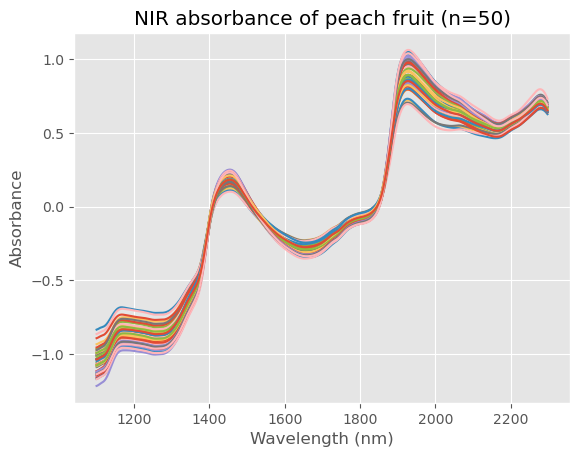

In [5]:
# separate output variable ('Brix') from all input variables (absorbance values)
y = data['Brix']

# convert dataframe into Numpy array; select all rows, select columns from the second one to the end
X = data.values[:,1:]

# create an array of evenly spaced values starting at 1100 and ending at 2299, in steps of 2; represents wavelengths (wl) in nm
wl = np.arange(1100,2300,2) 

# plot absorbance spectra
with plt.style.context(('ggplot')):
    plt.plot(wl, X.T)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absorbance')
    plt.title("NIR absorbance of peach fruit (n=50)")
plt.show()

In [9]:
# create the PCA object
pca = PCA()
 
# preprocessing (1)
# take the first derivative of the data to corrects for baseline differences
# use the savgol_filter to smooth the derivative data and increase stability
d1X = savgol_filter(X, 25, polyorder = 5, deriv=1)
 
# preprocess (2)
# standardise features by removing the mean and scaling to unit variance
scaler=StandardScaler()
Xstd = StandardScaler().fit_transform(d1X)
 
# run PCA producing the reduced variable Xreg and select the first pc components
# specify number of PCs
pc = 2
Xreg = pca.fit_transform(Xstd)[:,:pc]

PCA returns principle components where each PC consists of a weighted combination of the original variables. It aims to capture the maximum variance in the dataset without losing any of the original variables. Once we have a list of PCs we can use them in linear regression to model the relationship between the input variables (absorbance) and the output (Brix). It can then be used to determine Brix in test samples.

## Step 2. Linear regression

In [12]:
# initialise a linear regression model 
regr = linear_model.LinearRegression() 

# fit data to model 
regr.fit(Xreg, y) 

# predict on training data (calibration) 
y_c = regr.predict(Xreg) 

# cross-validation; 10-fold cv to get predictions for each data point without using that point in training
y_cv = cross_val_predict(regr, Xreg, y, cv=10) 

# calculate scores for calibration and cross-validation 
score_c = r2_score(y, y_c) 
score_cv = r2_score(y, y_cv)

# calculate mean square error for calibration and cross validation 
mse_c = mean_squared_error(y, y_c) 
mse_cv = mean_squared_error(y, y_cv)

In [14]:
# Combine both steps into a single function

def pcr(X,y,pc):

    # create the PCA object
    pca = PCA()
     
    # preprocessing (1): first derivative
    d1X = savgol_filter(X, 25, polyorder = 5, deriv=1)
     
    # preprocess (2): standardise
    Xstd = scaler.fit_transform(d1X)
     
    # run PCA producing the reduced variable Xreg and select the specified number of pc components
    Xreg = pca.fit_transform(Xstd)[:,:pc]    
    
    # initialise a linear regression model 
    regr = linear_model.LinearRegression() 
    
    # fit data to model 
    regr.fit(Xreg, y) 
    
    # calibration
    y_c = regr.predict(Xreg) 
    
    # cross-validation
    y_cv = cross_val_predict(regr, Xreg, y, cv=10) 
    
    # calculate scores for calibration and cross-validation 
    score_c = r2_score(y, y_c) 
    score_cv = r2_score(y, y_cv)
    
    # calculate mean square error for calibration and cross validation 
    mse_c = mean_squared_error(y, y_c) 
    mse_cv = mean_squared_error(y, y_cv)
    
    # return scores and mse to evaluate 
    return(y_cv, score_c, score_cv, mse_c, mse_cv)

In [16]:
# specify 20 primary components
pcr(X,y,20)

(array([15.42246062, 17.93121546, 15.64463353, 14.7740948 , 16.35965226,
        16.21137941, 19.17895668, 16.95251441, 19.39240982, 18.26834121,
        16.95804277, 17.14913797, 14.45210682, 15.04094474, 15.26361909,
        16.26408092, 11.94399114, 14.81507436, 16.16397625, 11.97206844,
        15.83090167, 15.97877711, 13.95086679, 15.68608604, 16.27683281,
        17.91333943, 17.8200788 , 14.81986622, 13.37248582, 16.96491804,
        19.42815688, 15.98490358, 14.14551075, 13.46845494, 20.58886427,
        15.63724293, 18.01356882, 17.82107529, 19.10439753, 12.99219723,
        15.04673153, 14.58829715, 19.26182893, 19.67584651, 16.32755744,
        19.47271545, 17.43473098, 18.93975579, 19.79152431, 15.99925776]),
 0.7292645552217021,
 0.1735460296909236,
 1.261492887886258,
 3.850865580471023)

In [18]:
# access output as variables outside function
y_cv, score_c, score_cv, mse_c, mse_cv = pcr(X, y, pc=20)

In [20]:
score_c, score_cv, mse_c, mse_cv

(0.7292645552217021, 0.1735460296909236, 1.261492887886258, 3.850865580471023)

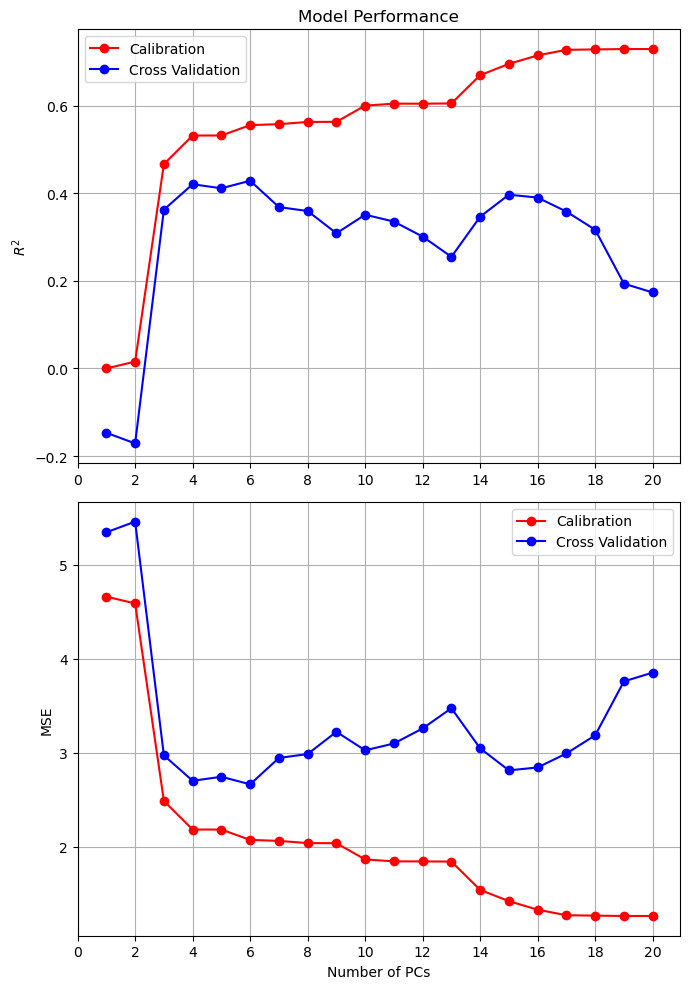

In [22]:
# compare scores at different numbers of PCs
max_pc = 20
scores_c = []
scores_cv = []
mses_c = []
mses_cv = []

for pc in range(1, max_pc + 1):
    _, score_c, score_cv, mse_c, mse_cv = pcr(X, y, pc) # skip y_cv as output
    scores_c.append(score_c)
    scores_cv.append(score_cv)
    mses_c.append(mse_c)
    mses_cv.append(mse_cv)

# plot scores
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(7, 10))

# Plot R² scores on the first subplot
ax1.plot(range(1, max_pc + 1), scores_c, 'o-r', label='Calibration')
ax1.plot(range(1, max_pc + 1), scores_cv, 'o-b', label='Cross Validation')
ax1.set_ylabel(r"$R^2$")
ax1.set_xticks(np.arange(0, max_pc + 1, step=2))
ax1.set_title("Model Performance")
ax1.legend()
ax1.grid(True)

# plot MSE on the second subplot
ax2.plot(range(1, max_pc + 1), mses_c, 'o-r', label='Calibration')
ax2.plot(range(1, max_pc + 1), mses_cv, 'o-b', label='Cross Validation')
ax2.set_xlabel("Number of PCs")
ax2.set_ylabel("MSE")
ax2.set_xticks(np.arange(0, max_pc + 1, step=2))
ax2.legend()
ax2.grid(True)

# adjust layout
plt.tight_layout()
plt.show()

## Result
The calibration improves with increasing principle components. However, the cross validation result gets worse when more than 6 principle components are used. 

## Run function with optimal number of PCs

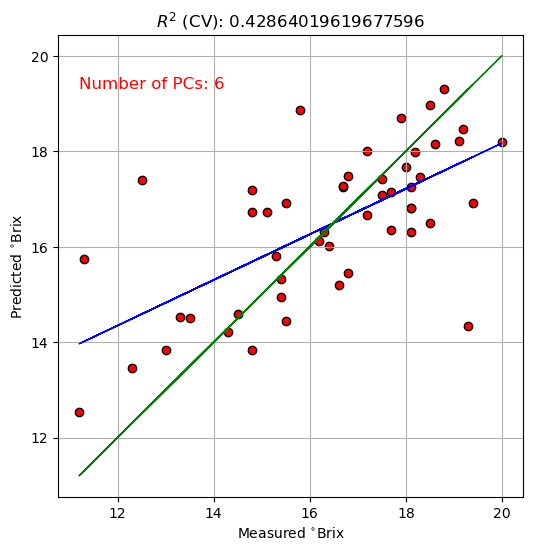

In [25]:
# run model with 6 PCs
pc = 6
predicted, r2r, r2cv, mser, mscv = pcr(X,y, pc)
 
# regression plot
# fit a 1st-degree polynomial (a straight line) to the data points defined by y (actual values) and predicted (model-predicted values)
z = np.polyfit(y, predicted, 1)
slope, intercept = z
equation = f"y = {slope:.2f}x + {intercept:.2f}"

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(y, predicted, c='red', edgecolors='k')
ax.plot(y, z[1]+z[0]*y, c='blue', linewidth=1)
ax.plot(y, y, color='green', linewidth=1)
plt.title('$R^{2}$ (CV): '+str(r2cv))
plt.xlabel('Measured $^{\circ}$Brix')
plt.ylabel('Predicted $^{\circ}$Brix')
plt.text(x=min(y), y=max(predicted), s=f'Number of PCs: {pc}', fontsize=12, color='red')
plt.grid(True)
plt.show()

The green line represents an R<sup>2</sup> of 1 (i.e. predicted and actual values are identical). The blue line is the correlation between the actual and predicted values using the model with 6 PCs with an R<sup>2</sup> of 0.43. This isn't great, and can be optimised using functions available in the scikit learn package (like GridSearchCV). Alternatively, a supervised learning approach can be used to create the model, like Partial Least Squares Regression, where we explicitly include the output variable in feature selection.

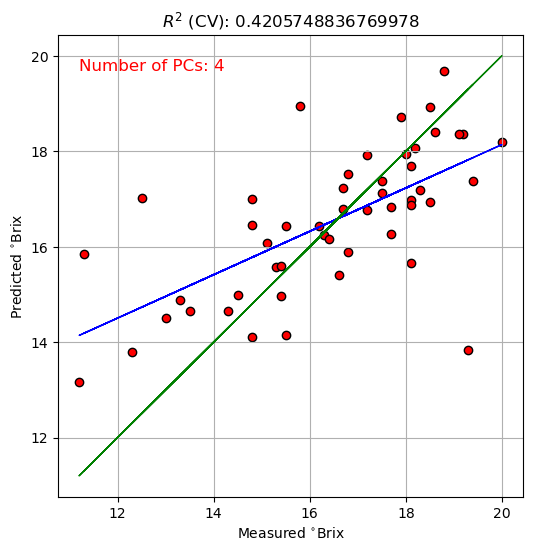

In [28]:
# run model with 4 PCs to compare
pc = 4
predicted, r2r, r2cv, mser, mscv = pcr(X,y, pc)
 
# regression plot
# fit a 1st-degree polynomial (a straight line) to the data points defined by y (actual values) and predicted (model-predicted values)
z = np.polyfit(y, predicted, 1)
slope, intercept = z
equation = f"y = {slope:.2f}x + {intercept:.2f}"

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(y, predicted, c='red', edgecolors='k')
ax.plot(y, z[1]+z[0]*y, c='blue', linewidth=1)
ax.plot(y, y, color='green', linewidth=1)
plt.title('$R^{2}$ (CV): '+str(r2cv))
plt.xlabel('Measured $^{\circ}$Brix')
plt.ylabel('Predicted $^{\circ}$Brix')
plt.text(x=min(y), y=max(predicted), s=f'Number of PCs: {pc}', fontsize=12, color='red')
plt.grid(True)
plt.show()

Using 4 PCs instead of 6 decreases the R<sup>2</sup> which shows that 6 PCs return a slightly better result. It is also evident that the predictive ability of the model is worse at lower Brix values (the difference between the green and blue lines is largest at Brix < 14). Taking measurements at a wider range could improve this.

## Equation to predict Brix
If we use 6 PCs then we have the following equation:  

$\text{Brix} = \beta_0 + \beta_1 \cdot \text{PC1} + \beta_2 \cdot \text{PC2} + \beta_3 \cdot \text{PC3} + \beta_4 \cdot \text{PC4} + \beta_5 \cdot \text{PC5} + \beta_6 \cdot \text{PC6}$

Where each PC consists of a combination of the 600 features (the wavelengths measured by the instrument). 

In [47]:
# extract coefficients and intercept for above equation

# start from scratch; first standardise data
scaler = StandardScaler()
Xstd = scaler.fit_transform(X)

# create a pca object specifying 6 components
pca = PCA(n_components = 6)

# fit standardised data to it
X_pca = pca.fit_transform(Xstd)

# linear regression on PCs
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_pca, y)

# regression coefficients in PC space
beta_pca = reg.coef_           
intercept_pca = reg.intercept_

print(intercept_pca, beta_pca)

16.436 [ 0.0017488   0.01432714  0.10951413 -0.43045224  0.40400483 -0.23071828]


Our updated equation is now:  

$\text{Brix} = 16.436 + \text{0.00175} \cdot \text{PC1} + \text{0.01433} \cdot \text{PC2} + \text{0.10951} \cdot \text{PC3} - \text{0.43045} \cdot \text{PC4} + \text{0.40400} \cdot \text{PC5} - \text{0.23072} \cdot \text{PC6}$

We have to incorporate the individual weights for each feature into the PC variables, accounting for standardisation, and then simplify for the final predictive model. This will allow the prediction of Brix based on the measurement of 600 wavelengths using a NIRS device.

In [62]:
# map back to original feature space
# components shape: (6, n_features)
# multiply (1 x 6) dot (6 x n_features) => (1 x n_features)
beta_original = np.dot(beta_pca, pca.components_)  # shape: (n_features,)

# account for standardization
beta_original_scaled = beta_original / scaler.scale_
intercept = y.mean() - np.dot(beta_original_scaled, X.mean(axis=0))

We now have a linear regression equation with 601 variables (intercept + 600 wavelengths * coefficient) that can predict Brix from wavelength data. Let's see how well this equation works using the original data.

In [65]:
# predict using the regression model in original space
y_pred = np.dot(X, beta_original_scaled) + intercept
residuals = y - y_pred

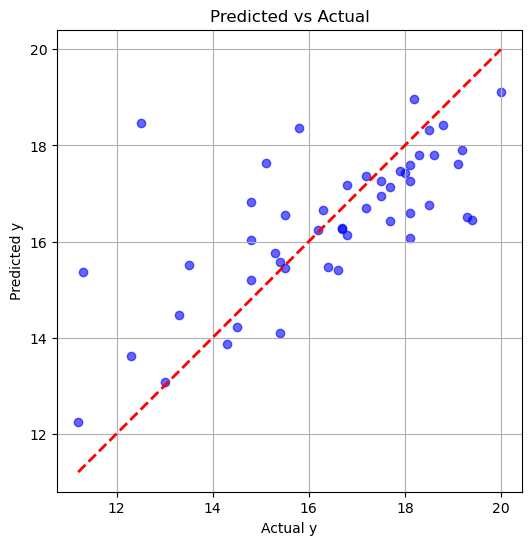

In [67]:
# graph predicted versus actual
plt.figure(figsize=(6,6))
plt.scatter(y, y_pred, color='blue', alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Predicted vs Actual')
plt.grid(True)
plt.axis('equal')
plt.show()

As before, the lower Brix values show greater variation.

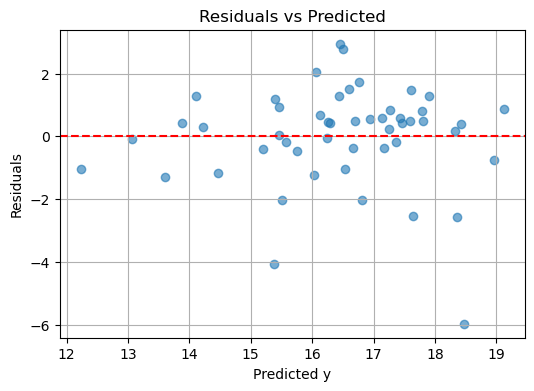

In [70]:
# plot residuals
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted y')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.grid(True)
plt.show()

No big problems observed here. The residuals scatter fairly randomly around 0 implying that the assumption of a linear relationship is reasonable. The residuals form a relatively uniform horizontal band around 0, with some more extreme values at about 15.5 (residual of -4) and 18.5 (residual of -6). Overall, this suggests variances of the error terms are equal although the two points noted in the previous sentence could be considered outliers. 


### Further resources  
For a good explanation of PCR, I can recommend [this video](https://youtu.be/SWfucxnOF8c) on YouTube.